# Setup

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "none"

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, auc, precision_score, recall_score
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pickle

pd.options.display.float_format = '{:,.2f}'.format

simulated_source = pd.read_csv('../data/interim/simulated.csv')

In [2]:
simulated_source.head()

,rooms,garages,useful_area,latitude,longitude,value,interior_quality,time_on_market,sold,value_log1p,value_log1p_zscore,time_on_market_agg
0,3.00,2.00,77,-23.62,-46.74,686126,2,75.84,0,13.44,-0.84,"(75, 90]"
1,1.00,1.00,35,-23.55,-46.65,675152,3,215.49,0,13.42,-0.87,"(210, 225]"
2,3.00,2.00,97,-23.61,-46.63,871258,2,92.05,0,13.68,-0.48,"(90, 105]"
3,3.00,3.00,102,-23.54,-46.57,648740,3,32.00,1,13.38,-0.93,"(30, 45]"
4,2.00,1.00,78,-23.59,-46.63,968643,2,319.57,0,13.78,-0.32,"(315, 330]"


In [3]:
simulated = simulated_source.copy()
simulated = simulated.iloc[:,:-3]
simulated.head()

,rooms,garages,useful_area,latitude,longitude,value,interior_quality,time_on_market,sold
0,3.00,2.00,77,-23.62,-46.74,686126,2,75.84,0
1,1.00,1.00,35,-23.55,-46.65,675152,3,215.49,0
2,3.00,2.00,97,-23.61,-46.63,871258,2,92.05,0
3,3.00,3.00,102,-23.54,-46.57,648740,3,32.00,1
4,2.00,1.00,78,-23.59,-46.63,968643,2,319.57,0


## Adição de colunas com preços reduzidos

In [4]:
simulated['value-5'] = simulated['value'] * 0.95
simulated['value-10'] = simulated['value'] * 0.90
simulated['value-15'] = simulated['value'] * 0.85
simulated['value-20'] = simulated['value'] * 0.80

### Lista com colunas de valores para dropar antes de classificar
artificial_values_list = ['value-5','value-10','value-15','value-20']

simulated.head()

,rooms,garages,useful_area,latitude,longitude,value,interior_quality,time_on_market,sold,value-5,value-10,value-15,value-20
0,3.00,2.00,77,-23.62,-46.74,686126,2,75.84,0,"651,819.70","617,513.40","583,207.10","548,900.80"
1,1.00,1.00,35,-23.55,-46.65,675152,3,215.49,0,"641,394.40","607,636.80","573,879.20","540,121.60"
2,3.00,2.00,97,-23.61,-46.63,871258,2,92.05,0,"827,695.10","784,132.20","740,569.30","697,006.40"
3,3.00,3.00,102,-23.54,-46.57,648740,3,32.00,1,"616,303.00","583,866.00","551,429.00","518,992.00"
4,2.00,1.00,78,-23.59,-46.63,968643,2,319.57,0,"920,210.85","871,778.70","823,346.55","774,914.40"


In [5]:
# Function to train the model
def train_regr(regrmodel):

    regrmodel = regrmodel

    regrmodel.fit(Xregr_train, yregr_train,
            eval_set = [(Xregr_train, yregr_train), (Xregr_test, yregr_test)],
            eval_metric = 'rmse',
            early_stopping_rounds = 5,
            verbose=True)

    best_iteration = regrmodel.get_booster().best_ntree_limit
    regrpreds = regrmodel.predict(Xregr_test, ntree_limit=best_iteration)
    
    return regrpreds, regrmodel, best_iteration


# Function to evaluate some metrics
def evaluate_metrics(regrpreds, yregr_test, Xregr_test, regrmodel, best_iteration):
    rmse = np.sqrt(mean_squared_error(yregr_test, regrpreds))
    r2 = r2_score(yregr_test, regrpreds, multioutput='variance_weighted')
    
    evals_result = regrmodel.evals_result()  
    plt.rcParams["figure.figsize"] = (8, 6)
    xgb.plot_importance(regrmodel, max_num_features=None,grid=False)
    plt.show()

    range_evals = np.arange(0, len(evals_result['validation_0']['rmse']))

    val_0 = evals_result['validation_0']['rmse']
    val_1 = evals_result['validation_1']['rmse']
    plt.figure(num=None, figsize=(8, 6), facecolor='w', edgecolor='k')
    plt.plot(range_evals, val_1, range_evals, val_0)
    plt.ylabel('Validation error')
    plt.xlabel('Iteration')
    plt.show()
    
    print("Best iteration: %f" % (int(best_iteration)))
    print("RMSE: %f" % (rmse))
    print("R2: %f" % (r2))
    print('Observed value single sample: {}'.format(yregr_test[0:1].tolist()[0]))
    print('Predicted value single sample: {}'.format(int(regrmodel.predict(Xregr_test[0:1], ntree_limit=best_iteration)[0])))

### Split
A mesma divisão será usada tanto para a previsão quanto para a classificação.

In [6]:
train, test = train_test_split(simulated, test_size=0.2, random_state=23)

In [7]:
###### dattasets para determinação de preço
Xregr_train = train.drop([*artificial_values_list,'value','sold'],axis=1)
yregr_train = train['value']

Xregr_test = test.drop([*artificial_values_list,'value','sold'],axis=1)
yregr_test = test['value']

###### dattasets para determinação de preço sem time on market
ntXregr_train = train.drop([*artificial_values_list,'value','sold','time_on_market'],axis=1)
ntyregr_train = train['value']

ntXregr_test = test.drop([*artificial_values_list,'value','sold','time_on_market'],axis=1)
ntyregr_test = test['value']



###### Class
Xclass_train = train.drop([*artificial_values_list,'sold'],axis=1)
yclass_train = train['sold']

################################
############ Arrumar ###########
################################
Xclass_test = test.drop('sold',axis=1)
yclass_test = test['sold']



In [8]:
Xregr_test

,rooms,garages,useful_area,latitude,longitude,interior_quality,time_on_market
2847,3.00,2.00,145,-23.55,-46.66,1,162.16
3508,2.00,2.00,84,-23.60,-46.61,1,94.00
710,3.00,1.00,98,-23.61,-46.65,1,94.00
482,2.00,1.00,40,-23.59,-46.69,3,175.97
1423,3.00,1.00,81,-23.53,-46.73,1,10.00
...,...,...,...,...,...,...,...
2912,2.00,1.00,61,-23.58,-46.64,2,199.00
6208,1.00,1.00,39,-23.64,-46.64,2,107.00
4016,4.00,3.00,244,-23.53,-46.73,2,19.13
328,2.00,2.00,60,-23.64,-46.67,3,127.00


# Predição do valor usando modelo XGBoost

### value com time_on_market

[0]	validation_0-rmse:1277975.00000	validation_1-rmse:1304143.00000
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:931409.62500	validation_1-rmse:951088.31250
[2]	validation_0-rmse:696631.56250	validation_1-rmse:712467.12500
[3]	validation_0-rmse:538006.00000	validation_1-rmse:556080.31250
[4]	validation_0-rmse:433912.78125	validation_1-rmse:460532.40625
[5]	validation_0-rmse:365902.15625	validation_1-rmse:402637.12500
[6]	validation_0-rmse:324516.93750	validation_1-rmse:369518.31250
[7]	validation_0-rmse:295670.40625	validation_1-rmse:348740.40625
[8]	validation_0-rmse:277957.09375	validation_1-rmse:339772.93750
[9]	validation_0-rmse:263967.50000	validation_1-rmse:331952.90625
[10]	validation_0-rmse:256661.89062	validation_1-rmse:329528.53125
[11]	validation_0-rmse:251326.20312	validation_1-rmse:327976.43750
[12]	validation_0-rmse:246543.43750	validation

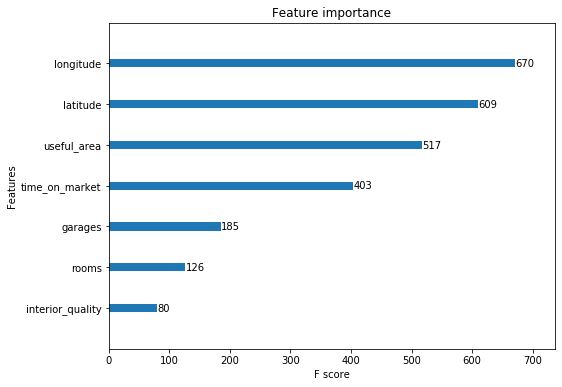

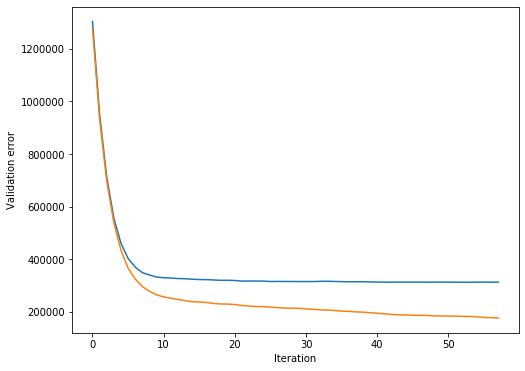

Best iteration: 54.000000
RMSE: 312173.789414
R2: 0.904939
Observed value single sample: 1624930
Predicted value single sample: 1527682


In [9]:
xg_regr = xgb.XGBRegressor()

regrpreds, regrmodel, best_iteration = train_regr(xg_regr)

# evaluate_metrics(regrpreds, regrmodel, best_iteration)
evaluate_metrics(regrpreds, yregr_test, Xregr_test, regrmodel, best_iteration)


# save model to file
pickle.dump(regrmodel, open("../models/value-regressor.pickle.pkl", "wb"))

## value sem time_on_market

[0]	validation_0-rmse:1278021.75000	validation_1-rmse:1304065.37500
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:931305.12500	validation_1-rmse:952117.50000
[2]	validation_0-rmse:696820.68750	validation_1-rmse:713277.18750
[3]	validation_0-rmse:538929.18750	validation_1-rmse:558631.87500
[4]	validation_0-rmse:435535.37500	validation_1-rmse:460167.46875
[5]	validation_0-rmse:369802.06250	validation_1-rmse:400882.28125
[6]	validation_0-rmse:327541.50000	validation_1-rmse:365895.53125
[7]	validation_0-rmse:303462.50000	validation_1-rmse:348636.78125
[8]	validation_0-rmse:285618.03125	validation_1-rmse:337216.25000
[9]	validation_0-rmse:275444.37500	validation_1-rmse:331961.84375
[10]	validation_0-rmse:267256.71875	validation_1-rmse:327414.65625
[11]	validation_0-rmse:260228.18750	validation_1-rmse:325729.46875
[12]	validation_0-rmse:256264.50000	validation

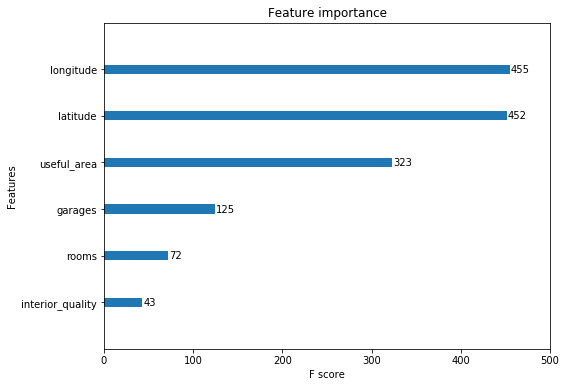

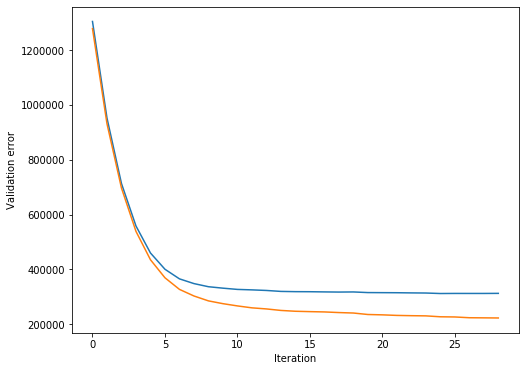

Best iteration: 25.000000
RMSE: 312435.270081
R2: 0.904780
Observed value single sample: 1624930
Predicted value single sample: 1458843


In [10]:
ntxg_regr = xgb.XGBRegressor()

ntxg_regr.fit(ntXregr_train, ntyregr_train,
            eval_set = [(ntXregr_train, ntyregr_train), (ntXregr_test, ntyregr_test)],
            eval_metric = 'rmse',
            early_stopping_rounds = 5,
            verbose=True)

ntbest_iteration = ntxg_regr.get_booster().best_ntree_limit
ntregrpreds = ntxg_regr.predict(ntXregr_test, ntree_limit=ntbest_iteration)


evaluate_metrics(ntregrpreds, ntyregr_test, ntXregr_test, ntxg_regr, ntbest_iteration)

pickle.dump(ntxg_regr, open("../models/value-regressor-notime.pickle.pkl", "wb"))

# Predição do valor dos imóveis vendidos usando XGBoost

In [11]:
def train_class(classmodel,Xclass_test):

    classmodel = classmodel

    try:
        Xclass_test = Xclass_test.drop(artificial_values_list,axis=1)
    except:
        pass

    classmodel.fit(Xclass_train, yclass_train,
            eval_set = [(Xclass_train, yclass_train), (Xclass_test, yclass_test)],
            eval_metric = 'aucpr',
            early_stopping_rounds = 5,
            verbose=True)

    xgb.plot_importance(classmodel, max_num_features=None,grid=False)
    xgb.plot_importance(classmodel, max_num_features=None,grid=False,importance_type='gain',xlabel='gain')
    
    best_iteration = classmodel.get_booster().best_ntree_limit
    classpreds = classmodel.predict(Xclass_test, ntree_limit=best_iteration)
    classpreds_proba = classmodel.predict_proba(Xclass_test, ntree_limit=best_iteration)
    
    return classpreds_proba, classpreds, classmodel, best_iteration

In [12]:
Xclass_test

,rooms,garages,useful_area,latitude,longitude,value,interior_quality,time_on_market,value-5,value-10,value-15,value-20
2847,3.00,2.00,145,-23.55,-46.66,1624930,1,162.16,"1,543,683.50","1,462,437.00","1,381,190.50","1,299,944.00"
3508,2.00,2.00,84,-23.60,-46.61,678651,1,94.00,"644,718.45","610,785.90","576,853.35","542,920.80"
710,3.00,1.00,98,-23.61,-46.65,692217,1,94.00,"657,606.15","622,995.30","588,384.45","553,773.60"
482,2.00,1.00,40,-23.59,-46.69,685313,3,175.97,"651,047.35","616,781.70","582,516.05","548,250.40"
1423,3.00,1.00,81,-23.53,-46.73,429364,1,10.00,"407,895.80","386,427.60","364,959.40","343,491.20"
...,...,...,...,...,...,...,...,...,...,...,...,...
2912,2.00,1.00,61,-23.58,-46.64,722747,2,199.00,"686,609.65","650,472.30","614,334.95","578,197.60"
6208,1.00,1.00,39,-23.64,-46.64,385129,2,107.00,"365,872.55","346,616.10","327,359.65","308,103.20"
4016,4.00,3.00,244,-23.53,-46.73,2005810,2,19.13,"1,905,519.50","1,805,229.00","1,704,938.50","1,604,648.00"
328,2.00,2.00,60,-23.64,-46.67,417122,3,127.00,"396,265.90","375,409.80","354,553.70","333,697.60"


[0]	validation_0-aucpr:0.71613	validation_1-aucpr:0.66917
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr hasn't improved in 5 rounds.
[1]	validation_0-aucpr:0.74013	validation_1-aucpr:0.68841
[2]	validation_0-aucpr:0.75300	validation_1-aucpr:0.69295
[3]	validation_0-aucpr:0.76451	validation_1-aucpr:0.69558
[4]	validation_0-aucpr:0.77219	validation_1-aucpr:0.69759
[5]	validation_0-aucpr:0.77792	validation_1-aucpr:0.70265
[6]	validation_0-aucpr:0.78131	validation_1-aucpr:0.70354
[7]	validation_0-aucpr:0.78795	validation_1-aucpr:0.70287
[8]	validation_0-aucpr:0.79230	validation_1-aucpr:0.70315
[9]	validation_0-aucpr:0.79672	validation_1-aucpr:0.71032
[10]	validation_0-aucpr:0.80161	validation_1-aucpr:0.70967
[11]	validation_0-aucpr:0.80815	validation_1-aucpr:0.71299
[12]	validation_0-aucpr:0.81125	validation_1-aucpr:0.71969
[13]	validation_0-aucpr:0.82195	validation_1-aucpr:0.72586
[14]	validation_0-aucpr:

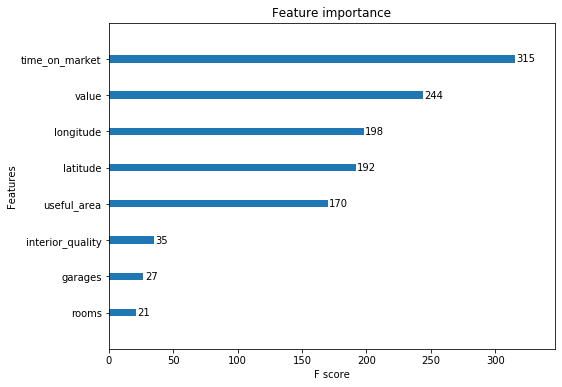

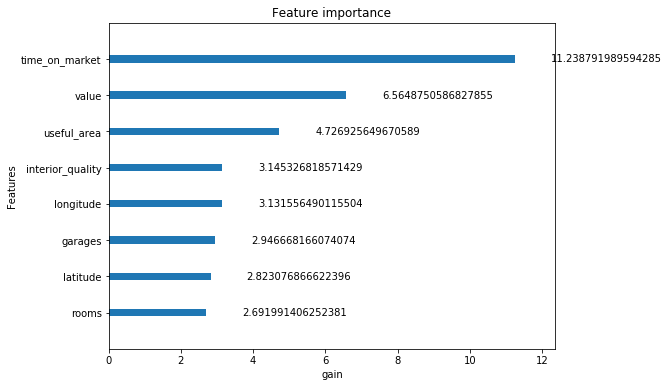

In [13]:
xg_class = xgb.XGBClassifier(objective='binary:logistic')

# try:
#     Xclass_test = Xclass_test.drop(artificial_values_list,axis=1)
# except:
#     pass
classpreds_proba, classpreds, classmodel, best_iteration = train_class(xg_class,Xclass_test)

pickle.dump(classmodel, open("../models/classifier.pickle.pkl", "wb"))

In [14]:
display(accuracy_score(yclass_test,classpreds),
        precision_score(yclass_test,classpreds),
        recall_score(yclass_test,classpreds))

0.7192353643966547

0.7089262613195343

0.691046658259773

In [15]:
confusion_matrix(yclass_test,classpreds,normalize='all')

array([[0.39187575, 0.1344086 ],
       [0.14635603, 0.32735962]])

In [16]:
(tn, fp, fn, tp) = confusion_matrix(yclass_test,classpreds).ravel()
(tn, fp, fn, tp)

(656, 225, 245, 548)

## Previsão usando preços reduzidos

In [17]:
Xclass_test

,rooms,garages,useful_area,latitude,longitude,value,interior_quality,time_on_market,value-5,value-10,value-15,value-20
2847,3.00,2.00,145,-23.55,-46.66,1624930,1,162.16,"1,543,683.50","1,462,437.00","1,381,190.50","1,299,944.00"
3508,2.00,2.00,84,-23.60,-46.61,678651,1,94.00,"644,718.45","610,785.90","576,853.35","542,920.80"
710,3.00,1.00,98,-23.61,-46.65,692217,1,94.00,"657,606.15","622,995.30","588,384.45","553,773.60"
482,2.00,1.00,40,-23.59,-46.69,685313,3,175.97,"651,047.35","616,781.70","582,516.05","548,250.40"
1423,3.00,1.00,81,-23.53,-46.73,429364,1,10.00,"407,895.80","386,427.60","364,959.40","343,491.20"
...,...,...,...,...,...,...,...,...,...,...,...,...
2912,2.00,1.00,61,-23.58,-46.64,722747,2,199.00,"686,609.65","650,472.30","614,334.95","578,197.60"
6208,1.00,1.00,39,-23.64,-46.64,385129,2,107.00,"365,872.55","346,616.10","327,359.65","308,103.20"
4016,4.00,3.00,244,-23.53,-46.73,2005810,2,19.13,"1,905,519.50","1,805,229.00","1,704,938.50","1,604,648.00"
328,2.00,2.00,60,-23.64,-46.67,417122,3,127.00,"396,265.90","375,409.80","354,553.70","333,697.60"


In [18]:
Xclass_test.columns.values[:-3]

array(['rooms', 'garages', 'useful_area', 'latitude', 'longitude',
       'value', 'interior_quality', 'time_on_market', 'value-5'],
      dtype=object)

In [19]:
a = Xclass_test.rename(columns={'value':'drop',
                                 'value-5':'value'})
a = a.drop(['drop','value-10','value-15','value-20'],axis=1)
a = a[Xclass_test.columns.values[:-4]]

classpreds5 = classmodel.predict(a, ntree_limit=best_iteration)

In [20]:
a = Xclass_test.rename(columns={'value':'drop',
                                 'value-10':'value'})
a = a.drop(['drop','value-5','value-15','value-20'],axis=1)
a = a[Xclass_test.columns.values[:-4]]

classpreds10 = classmodel.predict(a, ntree_limit=best_iteration)

In [21]:
a = Xclass_test.rename(columns={'value':'drop',
                                 'value-15':'value'})
a = a.drop(['drop','value-5','value-10','value-20'],axis=1)
a = a[Xclass_test.columns.values[:-4]]

classpreds15 = classmodel.predict(a, ntree_limit=best_iteration)

In [22]:
a = Xclass_test.rename(columns={'value':'drop',
                                 'value-20':'value'})
a = a.drop(['drop','value-5','value-10','value-15'],axis=1)
a = a[Xclass_test.columns.values[:-4]]

classpreds20 = classmodel.predict(a, ntree_limit=best_iteration)

# Análise dos modelos

In [23]:
res = test.copy()

### Resultado da regressão
res['yregr_test'] = yregr_test
res['regrpreds'] = regrpreds
res['dist'] = res['regrpreds'] - res['yregr_test']

### Resultado da classifcação
res['classpreds'] = classpreds
res['classpreds_proba'] = classpreds_proba[::,1::]
res['misclassified'] = res.apply(lambda x: x['classpreds']!=x['sold'],axis=1)

res['classpreds-5'] = classpreds5
res['classpreds-10'] = classpreds10
res['classpreds-15'] = classpreds15
res['classpreds-20'] = classpreds20

res.head()

,rooms,garages,useful_area,latitude,longitude,value,interior_quality,time_on_market,sold,value-5,...,yregr_test,regrpreds,dist,classpreds,classpreds_proba,misclassified,classpreds-5,classpreds-10,classpreds-15,classpreds-20
2847,3.00,2.00,145,-23.55,-46.66,1624930,1,162.16,0,"1,543,683.50",...,1624930,"1,527,682.50","-97,247.50",0,0.32,False,0,0,0,0
3508,2.00,2.00,84,-23.60,-46.61,678651,1,94.00,1,"644,718.45",...,678651,"745,831.12","67,180.12",1,0.67,False,1,1,1,1
710,3.00,1.00,98,-23.61,-46.65,692217,1,94.00,1,"657,606.15",...,692217,"907,575.06","215,358.06",1,0.76,False,1,1,1,1
482,2.00,1.00,40,-23.59,-46.69,685313,3,175.97,0,"651,047.35",...,685313,"604,237.00","-81,076.00",0,0.12,False,0,0,0,0
1423,3.00,1.00,81,-23.53,-46.73,429364,1,10.00,1,"407,895.80",...,429364,"647,666.06","218,302.06",1,0.83,False,1,1,1,1


In [24]:
display(res.sold.value_counts(),
        res.classpreds.value_counts())

0    881
1    793
Name: sold, dtype: int64

0    901
1    773
Name: classpreds, dtype: int64

In [25]:
display(res[res['classpreds'] != res['classpreds-5']].shape,
        res[res['classpreds'] != res['classpreds-10']].shape,
        res[res['classpreds'] != res['classpreds-15']].shape,
        res[res['classpreds'] != res['classpreds-20']].shape)

(80, 23)

(143, 23)

(218, 23)

(285, 23)

In [26]:
display(res[res['sold'] != res['classpreds']].shape,
        res[res['sold'] != res['classpreds-5']].shape,
        res[res['sold'] != res['classpreds-10']].shape,
        res[res['sold'] != res['classpreds-15']].shape,
        res[res['sold'] != res['classpreds-20']].shape)

(470, 23)

(464, 23)

(487, 23)

(502, 23)

(519, 23)

In [27]:
vendidos = res[res['sold']==1]

display(vendidos.shape,
        vendidos[vendidos['sold'] != vendidos['classpreds']].shape,
        vendidos[vendidos['sold'] != vendidos['classpreds-5']].shape,
        vendidos[vendidos['sold'] != vendidos['classpreds-10']].shape,
        vendidos[vendidos['sold'] != vendidos['classpreds-15']].shape,
        vendidos[vendidos['sold'] != vendidos['classpreds-20']].shape)

(793, 23)

(245, 23)

(215, 23)

(188, 23)

(162, 23)

(134, 23)

In [28]:
miss = res[res['misclassified']]
corr = res[~res['misclassified']]

In [29]:
display('Corretos',
        corr.groupby('classpreds')['time_on_market'].mean(),
        corr.groupby('classpreds')['value'].mean(),
        'Errados',
        miss.groupby('classpreds')['time_on_market'].mean(),
        miss.groupby('classpreds')['value'].mean())

'Corretos'

classpreds
0   179.30
1    51.59
Name: time_on_market, dtype: float64

classpreds
0   1,964,326.27
1   1,018,132.84
Name: value, dtype: float64

'Errados'

classpreds
0   136.91
1    66.43
Name: time_on_market, dtype: float64

classpreds
0   1,740,243.97
1   1,130,860.17
Name: value, dtype: float64

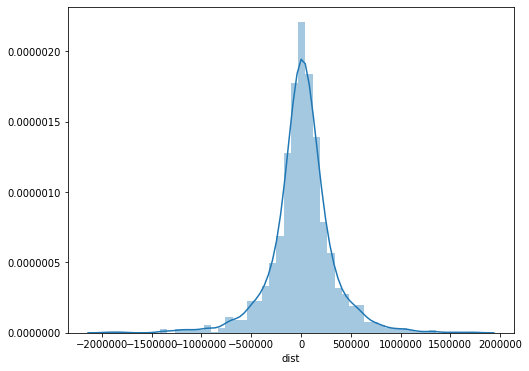

In [30]:
sns.distplot(res['dist'])

## Salvando com resultado da regressão e da classificação (mudar objetivo da classificação ,precision?)

# To-do: prever usando variação de preço, prever time_on_market

## Time on market

In [31]:
###### dattasets para determinação da liquidez
Xtime_train = train.drop([*artificial_values_list,'sold','time_on_market'],axis=1)
ytime_train = train['time_on_market']

Xtime_test = test.drop([*artificial_values_list,'sold','time_on_market'],axis=1)
ytime_test = test['time_on_market']

In [32]:
ytime_test

2847   162.16
3508    94.00
710     94.00
482    175.97
1423    10.00
        ...  
2912   199.00
6208   107.00
4016    19.13
328    127.00
501    161.00
Name: time_on_market, Length: 1674, dtype: float64

In [33]:
Xtime_test

,rooms,garages,useful_area,latitude,longitude,value,interior_quality
2847,3.00,2.00,145,-23.55,-46.66,1624930,1
3508,2.00,2.00,84,-23.60,-46.61,678651,1
710,3.00,1.00,98,-23.61,-46.65,692217,1
482,2.00,1.00,40,-23.59,-46.69,685313,3
1423,3.00,1.00,81,-23.53,-46.73,429364,1
...,...,...,...,...,...,...,...
2912,2.00,1.00,61,-23.58,-46.64,722747,2
6208,1.00,1.00,39,-23.64,-46.64,385129,2
4016,4.00,3.00,244,-23.53,-46.73,2005810,2
328,2.00,2.00,60,-23.64,-46.67,417122,3


[0]	validation_0-rmse:121.51765	validation_1-rmse:124.18198
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:105.46608	validation_1-rmse:108.96960
[2]	validation_0-rmse:96.07051	validation_1-rmse:100.40691
[3]	validation_0-rmse:90.79779	validation_1-rmse:95.74065
[4]	validation_0-rmse:87.69346	validation_1-rmse:93.41237
[5]	validation_0-rmse:85.69992	validation_1-rmse:92.24584
[6]	validation_0-rmse:84.35766	validation_1-rmse:91.86320
[7]	validation_0-rmse:83.36959	validation_1-rmse:91.48299
[8]	validation_0-rmse:82.90150	validation_1-rmse:91.31648
[9]	validation_0-rmse:81.91197	validation_1-rmse:91.28407
[10]	validation_0-rmse:81.52754	validation_1-rmse:91.21950
[11]	validation_0-rmse:81.21506	validation_1-rmse:91.26169
[12]	validation_0-rmse:80.72149	validation_1-rmse:91.27073
[13]	validation_0-rmse:80.41281	validation_1-rmse:91.22498
[14]	validation_0-rms

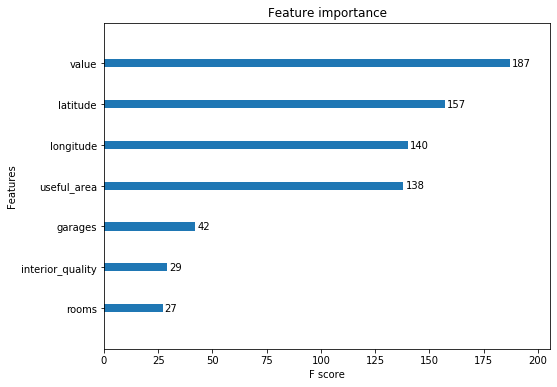

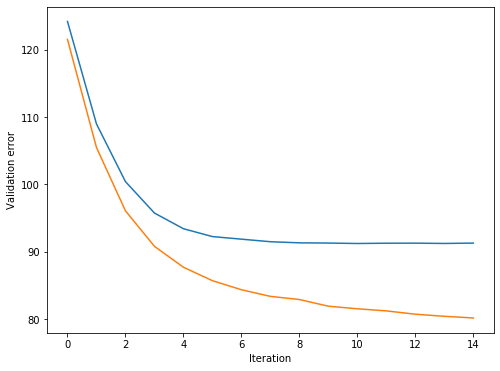

Best iteration: 11.000000
RMSE: 91.219503
R2: 0.089750
Observed value single sample: 162.1562628026571
Predicted value single sample: 108


In [34]:
xg_timeregr = xgb.XGBRegressor()

xg_timeregr.fit(Xtime_train, ytime_train,
            eval_set = [(Xtime_train, ytime_train), (Xtime_test, ytime_test)],
            eval_metric = 'rmse',
            early_stopping_rounds = 5,
            verbose=True)

timebest_iteration = xg_timeregr.get_booster().best_ntree_limit
timepreds = xg_timeregr.predict(Xtime_test, ntree_limit=timebest_iteration)


evaluate_metrics(timepreds, ytime_test, Xtime_test, xg_timeregr, timebest_iteration)

pickle.dump(xg_timeregr, open("../models/time-regressor.pickle.pkl", "wb"))

In [35]:
### Test
Xtime_test2 = test.drop(['sold','time_on_market'],axis=1)

b = Xtime_test2.rename(columns={'value':'drop',
                                'value-5':'value'})
b = b.drop(['drop','value-10','value-15','value-20'],axis=1)
b = b[Xtime_test2.columns.values[:-4]]

timepreds5 = xg_timeregr.predict(b, ntree_limit=timebest_iteration)

In [36]:
### Test
Xtime_test2 = test.drop(['sold','time_on_market'],axis=1)

b = Xtime_test2.rename(columns={'value':'drop',
                                'value-10':'value'})
b = b.drop(['drop','value-5','value-15','value-20'],axis=1)
b = b[Xtime_test2.columns.values[:-4]]

timepreds10 = xg_timeregr.predict(b, ntree_limit=timebest_iteration)

In [37]:
### Test
Xtime_test2 = test.drop(['sold','time_on_market'],axis=1)

b = Xtime_test2.rename(columns={'value':'drop',
                                'value-15':'value'})
b = b.drop(['drop','value-10','value-5','value-20'],axis=1)
b = b[Xtime_test2.columns.values[:-4]]

timepreds15 = xg_timeregr.predict(b, ntree_limit=timebest_iteration)

In [38]:
### Test
Xtime_test2 = test.drop(['sold','time_on_market'],axis=1)

b = Xtime_test2.rename(columns={'value':'drop',
                                'value-20':'value'})
b = b.drop(['drop','value-10','value-15','value-5'],axis=1)
b = b[Xtime_test2.columns.values[:-4]]

timepreds20 = xg_timeregr.predict(b, ntree_limit=timebest_iteration)

In [39]:
res['timepreds'] = timepreds
res['timepreds-5'] = timepreds5
res['timepreds-10'] = timepreds10
res['timepreds-15'] = timepreds15
res['timepreds-20'] = timepreds20

In [40]:
res

,rooms,garages,useful_area,latitude,longitude,value,interior_quality,time_on_market,sold,value-5,...,misclassified,classpreds-5,classpreds-10,classpreds-15,classpreds-20,timepreds,timepreds-5,timepreds-10,timepreds-15,timepreds-20
2847,3.00,2.00,145,-23.55,-46.66,1624930,1,162.16,0,"1,543,683.50",...,False,0,0,0,0,108.82,101.38,101.38,89.79,112.00
3508,2.00,2.00,84,-23.60,-46.61,678651,1,94.00,1,"644,718.45",...,False,1,1,1,1,74.13,82.64,77.97,77.97,72.04
710,3.00,1.00,98,-23.61,-46.65,692217,1,94.00,1,"657,606.15",...,False,1,1,1,1,78.33,78.87,78.87,62.49,56.56
482,2.00,1.00,40,-23.59,-46.69,685313,3,175.97,0,"651,047.35",...,False,0,0,0,0,139.74,134.34,134.34,126.49,116.74
1423,3.00,1.00,81,-23.53,-46.73,429364,1,10.00,1,"407,895.80",...,False,1,1,1,1,44.80,27.49,43.69,43.69,43.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,2.00,1.00,61,-23.58,-46.64,722747,2,199.00,1,"686,609.65",...,True,0,0,0,0,128.79,120.78,107.56,107.56,99.72
6208,1.00,1.00,39,-23.64,-46.64,385129,2,107.00,1,"365,872.55",...,False,1,1,1,1,98.79,98.79,90.98,75.86,74.33
4016,4.00,3.00,244,-23.53,-46.73,2005810,2,19.13,0,"1,905,519.50",...,False,0,0,1,1,138.01,153.08,146.90,146.90,147.40
328,2.00,2.00,60,-23.64,-46.67,417122,3,127.00,1,"396,265.90",...,False,1,1,1,1,53.93,53.93,53.93,53.93,51.11


In [41]:
res['dist20'] = res['timepreds-20'] - res['timepreds']
res['dist15'] = res['timepreds-15'] - res['timepreds']
res['dist10'] = res['timepreds-10'] - res['timepreds']
res['dist5'] = res['timepreds-5'] - res['timepreds']

/Users/VFX/Coding/GitHub/portfolio-strategy/.env/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


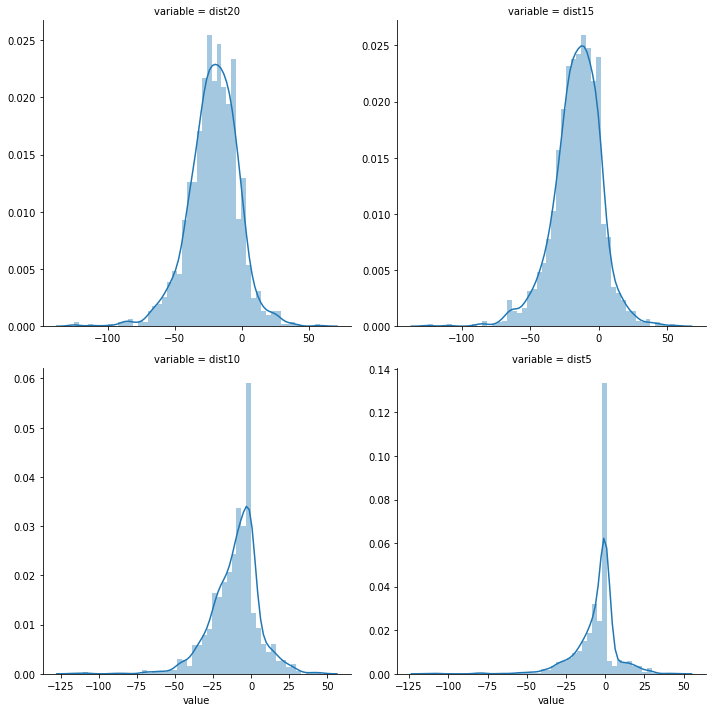

In [42]:
def distplot(x, **kwargs):
    sns.distplot(x)

var_list = ['dist20','dist15','dist10','dist5']

f = pd.melt(res, value_vars=var_list)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(distplot,"value")

In [43]:
f

,variable,value
0,dist20,3.18
1,dist20,-2.09
2,dist20,-21.76
3,dist20,-23.01
4,dist20,-1.12
...,...,...
6691,dist5,-8.02
6692,dist5,0.00
6693,dist5,15.07
6694,dist5,0.00


In [44]:
f.groupby('variable')['value'].mean()

variable
dist10   -10.17
dist15   -15.81
dist20   -21.16
dist5     -5.42
Name: value, dtype: float32

In [45]:
def pos(x):
    return x > 0
f['increase'] = f.value.apply(pos)

f.groupby('variable')['increase'].value_counts(normalize=True)

variable  increase
dist10    False      0.84
          True       0.16
dist15    False      0.87
          True       0.13
dist20    False      0.91
          True       0.09
dist5     False      0.87
          True       0.13
Name: increase, dtype: float64

## Save

In [46]:
res.to_csv('../data/interim/model_analysis.csv')